In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0.1.Import libraries

In [ ]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import json
import csv
from progressbar import progressbar
import requests
import math

In [ ]:
%cd '/content/drive/Shared drives/SI650/dataset/'

/content/drive/Shared drives/SI650/dataset


In [ ]:
import datetime
# Convert back to datetime object
def convert_to_time_obj(timestamp):
  return datetime.datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.000+00:00')

## 1.Exploratory Data Analysis

## 1.1.Load dataset

In [ ]:
df_clean = pd.read_csv('sephora_review_skincare_db_id.csv')

In [ ]:
df_clean.sample(10)

,brand,name,brand_id,brand_image_url,product_id,product_image_url,rating,skin_type,eye_color,skin_concerns,incentivized_review,skin_tone,age,beauty_insider,user_name,review_text,price,recommended,first_submission_date,last_submission_date,location,description,user_id,first_datetime,year,month,day,weekday,hour,timestamp
279536,CLINIQUE,Take The Day Off Cleansing Balm,1254,NaN,P126301,https://www.sephora.com/productimages/sku/s886...,5,normal,brown,acne,NaN,tan,NaN,NaN,emak9,amazing. effortlessly takes off all my makeup ...,$10.00 - $31.00,True,2018-08-25T02:29:42.000+00:00,2018-08-25T02:30:02.000+00:00,NaN,"What it is: A gentle, effective makeup remove...",148280,2018-08-25 02:29:42,2018,8,25,Sat,2,1535164182000000000
381026,IT Cosmetics,Secret Sauce Anti-Aging Moisturizer,6175,NaN,P421958,https://www.sephora.com/productimages/sku/s198...,5,combination,NaN,acne,True,light,NaN,NaN,arnorris21,I loved my it cosmetics. I will never use anyt...,$20.00 - $68.00,True,2019-06-13T17:15:07.000+00:00,2019-06-25T00:16:15.000+00:00,NaN,What it is: A luxurious face moisturizer that...,118912,2019-06-13 17:15:07,2019,6,13,Thu,17,1560446107000000000
113273,IT Cosmetics,CC+ Cream with SPF 50+,6175,NaN,P411885,https://www.sephora.com/productimages/sku/s186...,5,dry,green,NaN,NaN,olive,45to54,NaN,greeneyes6619,I like the color and the coverage,$15.50 - $39.50,True,2017-09-14T15:52:12.000+00:00,2017-09-14T16:00:04.000+00:00,NaN,"What it is: A color-correcting, full-coverage ...",157141,2017-09-14 15:52:12,2017,9,14,Thu,15,1505404332000000000
154881,Drunk Elephant,Virgin Marula Luxury Face Oil,7083,NaN,P392245,https://www.sephora.com/productimages/sku/s167...,5,normal,hazel,blackheads,NaN,medium,NaN,NaN,talinm10,I use this every night and it is so hydrating ...,$40.00 - $72.00,True,2018-12-12T02:04:27.000+00:00,2018-12-12T02:15:05.000+00:00,NaN,What it is: A face oil rich in critical antio...,241728,2018-12-12 02:04:27,2018,12,12,Wed,2,1544580267000000000
21265,LANEIGE,Lip Sleeping Mask,6125,NaN,P420652,https://www.sephora.com/productimages/sku/s213...,5,combination,hazel,NaN,False,fair,NaN,NaN,lenocj,Love this product! I can tell a total differe...,$22.00,True,2019-08-22T03:57:26.000+00:00,2019-08-22T04:15:03.000+00:00,NaN,What it is: A leave-on lip mask that soothes a...,187569,2019-08-22 03:57:26,2019,8,22,Thu,3,1566446246000000000
245320,Biossance,Squalane + Marine Algae Eye Cream,6195,NaN,P447210,https://www.sephora.com/productimages/sku/s226...,5,normal,green,dullness,True,light,NaN,NaN,notnenna,I love this eye cream. I’ve used others in the...,$54.00,True,2019-08-10T02:32:16.000+00:00,2019-08-12T02:30:05.000+00:00,NaN,What it is: A hydrating cream that quickly an...,214421,2019-08-10 02:32:16,2019,8,10,Sat,2,1565404336000000000
360280,Origins,Checks and Balances™ Frothy Face Wash,3733,NaN,P297516,https://www.sephora.com/productimages/sku/s137...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monicaab,I really liked it for the first week. It was v...,$13.00 - $24.00,NaN,2013-09-13T07:43:43.000+00:00,2013-09-13T07:45:02.000+00:00,NaN,What it is: A bestselling face wash that easi...,207195,2013-09-13 07:43:43,2013,9,13,Fri,7,1379058223000000000
63258,Fresh,Soy Makeup Removing Face Wash,4348,NaN,P7880,https://www.sephora.com/productimages/sku/s487...,5,normal,NaN,NaN,NaN,light,45to54,yes,dreamyone,I was given a large sample of this cleanser. I...,$15.00 - $69.00,NaN,2010-01-28T05:48:31.000+00:00,2019-05-08T04:31:10.000+00:00,"Chapel Hill, NC",What it is: A bestselling three-in-one face wa...,145507,2010-01-28 05:48:31,2010,1,28,Thu,5,1264657711000000000
229790,Glow Recipe,Watermelon Glow PHA +BHA Pore-Tight Toner,6189,NaN,P458219,https://www.sephora.com/productimages/sku/s234...,5,normal,green,blackheads,True,fair,NaN,NaN,maureenleanna,Love this! Smells great and feels great on my ...,$34.00,True,2020-06-01T23:14:34.000+00:00,2020-06-05T19:28:50.000+00:00,NaN,"What it is: A gentle, PHA- and BHA-infused wa...",199252,2020-06-01 23:14:34,2020,6,1,Mon,23,1591053274

## 1.2.Cleaning data

In [ ]:
df_clean = df_clean.drop_duplicates()

In [ ]:
df_clean['pair_user_product'] = df_clean.user_id.astype(str) + "_" + df_clean.product_id
df_clean = df_clean.drop_duplicates(subset='pair_user_product')

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366754 entries, 0 to 413080
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   brand                  366754 non-null  object 
 1   name                   366754 non-null  object 
 2   brand_id               366754 non-null  int64  
 3   brand_image_url        0 non-null       float64
 4   product_id             366754 non-null  object 
 5   product_image_url      366754 non-null  object 
 6   rating                 366754 non-null  int64  
 7   skin_type              293332 non-null  object 
 8   eye_color              258091 non-null  object 
 9   skin_concerns          221265 non-null  object 
 10  incentivized_review    211533 non-null  object 
 11  skin_tone              282835 non-null  object 
 12  age                    86587 non-null   object 
 13  beauty_insider         59805 non-null   object 
 14  user_name              366754 non-nu

In [ ]:
# high ratings (rating 3-5) >> recommend
df_clean_high_rate = df_clean[df_clean['rating'] >= 4]
df_clean_high_rate.recommended.value_counts()

True     200987
False      1515
Name: recommended, dtype: int64

In [ ]:
# low ratings (rating 1 and 2) >> not recommend
df_clean_low_rate = df_clean[~(df_clean['rating'] >= 4)]
df_clean_low_rate.recommended.value_counts()

False    45316
True      7254
Name: recommended, dtype: int64

In [ ]:
# 255242 unique user_id
df_clean.user_id.value_counts()

167502    75
77023     43
45311     42
120840    41
151492    36
          ..
36751      1
40845      1
44939      1
42890      1
0          1
Name: user_id, Length: 255242, dtype: int64

In [ ]:
df_clean.brand.value_counts()

Drunk Elephant                26098
OLEHENRIKSEN                  25125
Fresh                         24302
Sol de Janeiro                19122
Tatcha                        18085
                              ...  
Nécessaire                       88
NuFACE                           84
The Original MakeUp Eraser       23
TOM FORD                         18
L'Occitane                       12
Name: brand, Length: 72, dtype: int64

# 1.2.Heatmap count of reviews by Month and Year

In [ ]:
df_clean['first_datetime'] = df_clean['first_submission_date'].map(convert_to_time_obj)

The users have started to reviews since 2017

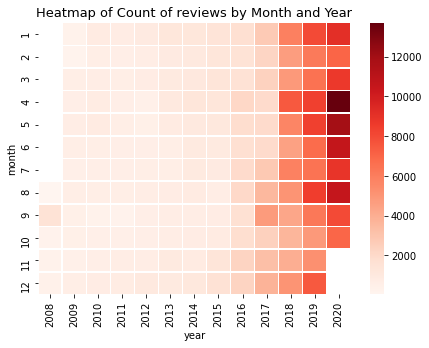

In [ ]:
yearly_table = df_clean['first_datetime'].groupby([df_clean['first_datetime'].dt.year.rename('year'),
                                       df_clean['first_datetime'].dt.month.rename('month')]).agg({'count'})
yearly_table = yearly_table.reset_index().pivot('month', 'year', 'count')
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(yearly_table, annot=False, fmt="f", linewidths=.5, ax=ax, cmap="Reds")
ax.axes.set_title("Heatmap of Count of reviews by Month and Year", fontsize=13, y=1.01);

They mostly reviewed products on Monday, Tueday, and Wednesday evening till early morning on the next day

# 1.3.Heatmap count of reviews by weekday and time

[Text(42.0, 0.5, 'Hour'), Text(0.5, 60.0, 'Day of Week')]

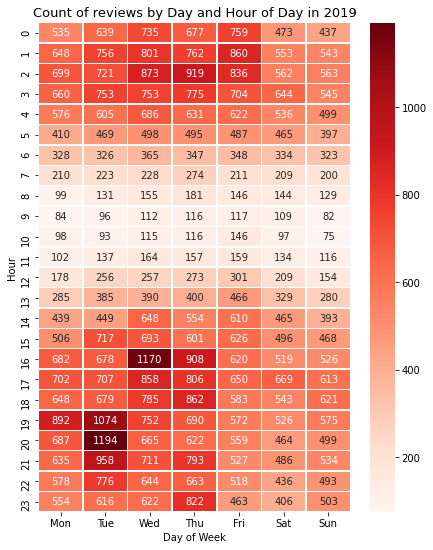

In [ ]:
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekly_table = df_clean[df_clean['year'] == 2019]['first_datetime'].groupby([df_clean['first_datetime'].dt.weekday.rename('weekday'),
                                       df_clean['first_datetime'].dt.hour.rename('hour')]).agg({'count'})
weekly_table = weekly_table.reset_index().pivot('hour', 'weekday', 'count')

f, ax = plt.subplots(figsize=(7, 9))
ax = sns.heatmap(weekly_table, annot=True, fmt="d", linewidths=.5, ax=ax,
                 xticklabels=weekdays,  cmap="Reds")
ax.axes.set_title("Count of reviews by Day and Hour of Day in 2019",
                  fontsize=13, y=1.01)
ax.set(xlabel='Day of Week', ylabel='Hour')

# 1.4. The long-tail of product popularity

In [ ]:
# Summary plot of words which have same frequency. 
# x - number of appearances, word_frequency
# y - how many words (frequency) appears in each particular number, number_such_words
def set_plot_frequency(tokens):
    
    # get dictionary (word: x)
    count_token = Counter(tokens)
    # get dictionary (x: y)
    counter_of_counts = Counter(count_token.values())
    # sorted by y 
    counter_of_counts = sorted(counter_of_counts.items(), key=lambda pair: pair[0])
    
    word_frequency = np.asarray(counter_of_counts)[:,0]
    number_such_words = np.asarray(counter_of_counts)[:,1]
    number_such_words = number_such_words.astype('int')
    #plot
    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.plot(word_frequency, number_such_words)
    plt.xlabel('Product frequency')
    plt.ylabel('number of such products')
    plt.title('Product distribution')
    #plt.grid(True)
    
    plt.subplots_adjust(wspace=0.5)
    
    plt.subplot(1, 2, 2)
    plt.plot(np.log(word_frequency), np.log(number_such_words))
    plt.xlabel('Log of product frequency')
    plt.ylabel('Log of number of such products')
    plt.title('Power law for product frequencies')
    #plt.grid(True)

    return plt.show()

Create product_id list by the number of review_text

In [ ]:
df_clean_drop = df_clean.dropna(subset=['review_text'])

In [ ]:
count_token = Counter(prod_list)
sorted_count_token = sorted(count_token.items(), key = lambda pair: pair[1], reverse = True)
word_frequency = np.asarray(sorted_count_token)[:,0]
frequency = np.asarray(sorted_count_token)[:, 1]
frequency = frequency.astype('int')

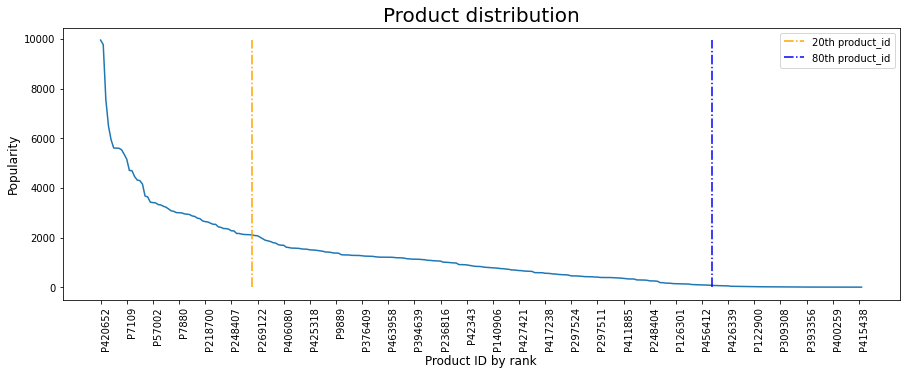

In [ ]:
plt.figure(figsize=(15,5))
# fig = plt.figure(figsize=(15,5))
plt.plot(word_frequency, frequency)
plt.xlabel('Product ID by rank', fontsize=12)
plt.ylabel('Popularity', fontsize=12)
plt.xticks(np.arange(0, len(word_frequency), 10), word_frequency, rotation=90, ha='left');
# plt.yticks(np.arange(0, len(frequency), 1000), frequency, va='bottom');
# 20% 
plt.plot(["P124716", "P124716"], [-1, max], '-.', c='orange', label="20th product_id")
# 80%
plt.plot(["P435378", "P435378"], [-1, max], '-.', c='blue', label="80th product_id")
plt.title('Product distribution', fontsize=20)
plt.legend()

In [ ]:
# Short head
short_product_id = word_frequency[:57]
short_product_id

array(['P420652', 'P7109', 'P57002', 'P7880', 'P218700', 'P248407',
       'P269122', 'P406080', 'P425318', 'P9889', 'P376409', 'P463958',
       'P394639', 'P236816', 'P42343', 'P140906', 'P427421', 'P417238',
       'P297524', 'P297511', 'P411885', 'P248404', 'P126301', 'P456412',
       'P426339', 'P122900', 'P309308', 'P393356', 'P400259', 'P415438',
       'P409800', 'P427417', 'P443825', 'P54477', 'P6025', 'P429952',
       'P418218', 'P411387', 'P411540', 'P392246', 'P302923', 'P394624',
       'P421275', 'P232903', 'P430337', 'P42342', 'P297516', 'P302103',
       'P420651', 'P439061', 'P443563', 'P94421', 'P442563', 'P278317',
       'P415777', 'P232915', 'P393718'], dtype='<U9')

In [ ]:
# Long tail
long_product_id = word_frequency[58:234]
long_product_id

array(['P124716', 'P426836', 'P406712', 'P422905', 'P410400', 'P461933',
       'P461159', 'P427419', 'P42318', 'P427536', 'P442536', 'P381030',
       'P427406', 'P454380', 'P458219', 'P399623', 'P287700', 'P434363',
       'P441101', 'P270594', 'P426340', 'P461537', 'P400207', 'P432829',
       'P431180', 'P392235', 'P456615', 'P434548', 'P429722', 'P415701',
       'P406686', 'P432668', 'P456446', 'P428819', 'P392245', 'P439058',
       'P440312', 'P174502', 'P416816', 'P446938', 'P427416', 'P439926',
       'P433435', 'P109936', 'P461555', 'P431848', 'P429515', 'P447780',
       'P428628', 'P379510', 'P416815', 'P448211', 'P307405', 'P440307',
       'P447791', 'P425416', 'P411388', 'P428250', 'P410873', 'P462699',
       'P455418', 'P415771', 'P448203', 'P427414', 'P377533', 'P417936',
       'P427420', 'P442566', 'P416563', 'P433520', 'P439055', 'P421996',
       'P427415', 'P443840', 'P443845', 'P375849', 'P429244', 'P419223',
       'P433626', 'P422000', 'P454120', 'P417312', '

In [ ]:
# Distant tail
distant_product_id = word_frequency[235:]
distant_product_id

array(['P455339', 'P457684', 'P458207', 'P455924', 'P457857', 'P455622',
       'P447773', 'P460831', 'P450947', 'P454821', 'P465369', 'P463949',
       'P463471', 'P461949', 'P455923', 'P458577', 'P411716', 'P461489',
       'P462677', 'P461538', 'P461447', 'P460833', 'P452000', 'P460832',
       'P456220', 'P460830', 'P462337', 'P462680', 'P463936', 'P461484',
       'P462756', 'P462742', 'P461179', 'P462707', 'P463815', 'P463941',
       'P461441', 'P461440', 'P461462', 'P460834', 'P464801', 'P462744',
       'P463291', 'P463966', 'P460840', 'P462755', 'P462676', 'P461155',
       'P462750', 'P463952', 'P465337', 'P455611', 'P461156', 'P463938',
       'P461448', 'P462731', 'P460839'], dtype='<U9')

# 1.5. Check data in each group

In [ ]:
df_short = df_clean_drop[df_clean_drop.product_id.isin(short_product_id)]
df_short.recommended.value_counts()

True     97669
False    21456
Name: recommended, dtype: int64

In [ ]:
df_short.rating.value_counts()

5    137115
4     34425
3     14209
1     13306
2     11315
Name: rating, dtype: int64

In [ ]:
df_long = df_clean_drop[df_clean_drop.product_id.isin(long_product_id)]
df_long.recommended.value_counts()

True     107632
False     24454
Name: recommended, dtype: int64

In [ ]:
df_distant = df_clean_drop[df_clean_drop.product_id.isin(distant_product_id)]
df_distant.recommended.value_counts()

True     705
False    155
Name: recommended, dtype: int64

In [ ]:
df_distant.rating.value_counts()

5    580
4    109
1     76
3     57
2     42
Name: rating, dtype: int64

In [ ]:
df_short.rating.value_counts()[5] / df_short.rating.value_counts().sum() * 100

65.1780196796121

In [ ]:
df_long.rating.value_counts()[5] / df_long.rating.value_counts().sum() * 100

62.22772049799502

In [ ]:
df_distant.rating.value_counts()[5] / df_distant.rating.value_counts().sum() * 100

67.12962962962963

# 1.6. Find most reviews skincare brand


In [ ]:
gr_brand_2 = pd.DataFrame(df_clean.groupby(['brand']).description.count())
# gr_brand['num'] = [sum(x) for x in gr_brand.name]
gr_brand_2 = gr_brand_2.sort_values('description', ascending=False)
gr_brand_2.head(5)

,description
brand,
Drunk Elephant,26098
OLEHENRIKSEN,25125
Fresh,24302
Sol de Janeiro,19122
Tatcha,18085


In [ ]:
gr_brand_3 = pd.DataFrame(df_long.groupby(['brand']).description.count())
# gr_brand['num'] = [sum(x) for x in gr_brand.name]
gr_brand_3 = gr_brand_3.sort_values('description', ascending=False)
gr_brand_3.head(5)

,description
brand,
Tatcha,15164
Drunk Elephant,13900
The Ordinary,12774
OLEHENRIKSEN,10219
Fresh,7864


In [ ]:
gr_brand_4 = pd.DataFrame(df_short.groupby(['brand']).description.count())
# gr_brand['num'] = [sum(x) for x in gr_brand.name]
gr_brand_4 = gr_brand_4.sort_values('description', ascending=False)
gr_brand_4.head(5)

,description
brand,
Fresh,16395
Sol de Janeiro,15755
OLEHENRIKSEN,14850
LANEIGE,14513
Drunk Elephant,11985


# 1.7.Find most reviews skincare brand and name

In [ ]:
gr_brand = pd.DataFrame(df_clean.groupby(['brand', 'name']).description.count())
gr_brand = gr_brand.sort_values('description', ascending=False).reset_index()
gr_brand.head(10)

,brand,name,description
0,LANEIGE,Lip Sleeping Mask,9954
1,philosophy,Purity Made Simple Cleanser,9772
2,Fresh,Sugar Lip Balm Sunscreen SPF 15,7553
3,Fresh,Soy Makeup Removing Face Wash,6495
4,Josie Maran,100 percent Pure Argan Oil,5940
5,First Aid Beauty,Ultra Repair® Cream Intense Hydration,5607
6,Dr. Dennis Gross Skincare,Alpha Beta® Extra Strength Daily Peel,5602
7,Sol de Janeiro,Brazilian Bum Bum Cream,5597
8,Sol de Janeiro,Mini Brazilian Bum Bum Cream,5536
9,Smashbox,The Original Photo Finish Smooth & Blur Oil-Fr...,5357


# 1.8. Filter out to get only recommended products

In [ ]:
# most recommended data are missing >> so the data was lost in a half
target_ix = df_clean[df_clean.recommended==True]

In [ ]:
prod_rec = target_ix.loc[:, ['brand', 'name', 'skin_tone', 'skin_concerns', 'recommended']]

In [ ]:
gr_bran_pi = pd.DataFrame(prod_rec.groupby(['brand', 'name'], as_index= False).agg({
  'recommended' : "count"

}))
#  gr_brand['num'] = [sum(x) for x in gr_brand.name]
gr_bran_pi = gr_bran_pi.sort_values('recommended', ascending=False)
# gr_bran_pi.reset_index()
gr_bran_pi

,brand,name,recommended
128,LANEIGE,Lip Sleeping Mask,8269
28,Dr. Dennis Gross Skincare,Alpha Beta® Extra Strength Daily Peel,4024
217,Sol de Janeiro,Brazilian Bum Bum Cream,3572
221,Sol de Janeiro,Mini Brazilian Bum Bum Cream,3534
68,Farmacy,Green Clean Makeup Removing Cleansing Balm,3080
...,...,...,...
91,Fresh,Sugar Lip Moisturizing Trio,1
181,SEPHORA COLLECTION,Enchanted Jungle Set,1
206,Shiseido,Benefiance Wrinkle Smoothing Essentials Set,1
27,Dr. Dennis Gross Skincare,All is Bright FaceWare Pro Set,1


In [ ]:
gr_bran_pi['brand_name'] = gr_bran_pi['brand'] + " : " + gr_bran_pi['name']

Text(0.5, 1.0, 'Top 25 Product Recommended')

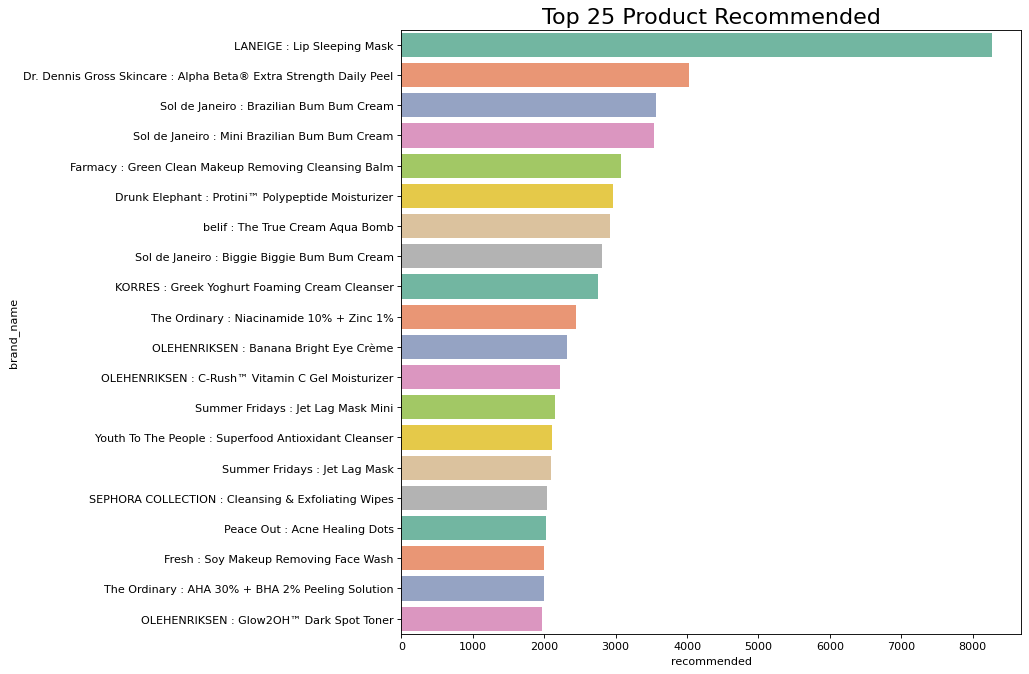

In [ ]:
plt.figure(figsize=(10,10), dpi=80)
sns.barplot(data=gr_bran_pi[0:20], x='recommended', y='brand_name',palette="Set2")
plt.title('Top 25 Product Recommended', fontsize=20)